## Librerías

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, RobustScaler
from keras import models, optimizers, regularizers
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns

2022-11-20 15:55:38.314476: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Cargar Datos

In [2]:
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")
gs_df = pd.read_csv("../data/gender_submission.csv")

In [3]:
print(f"Dimensiones Train: {train_df.shape}")
print(f"Dimensiones Test: {test_df.shape}")
print(f"Dimensiones Gender Submission: {gs_df.shape}")

Dimensiones Train: (891, 12)
Dimensiones Test: (418, 11)
Dimensiones Gender Submission: (418, 2)


Agregamos la columna *Survived* del archivo *gender_submission* como columna *Survived* del DataFrame de *test*.

In [4]:
test_df["Survived"] = gs_df["Survived"]

In [5]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


## Preprocesamiento de datos

### Eliminar columnas irrelevantes

Definimos que las columnas *PassengerId*, *Name*, *Ticket* y *Cabin* no aportan información relevante al modelo, además de que en algunos casos tienen una gran cantidad de valores vacíos, por lo tanto las sacamos de los DataFrames.

In [7]:
train_df.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis = 1, inplace = True)
test_df.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis = 1, inplace = True)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       332 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      417 non-null    float64
 6   Embarked  418 non-null    object 
 7   Survived  418 non-null    int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 26.2+ KB


Se aprecia que ambos DataFrames tienen valores vacíos, principalmente en la feature de *Age*. 

### Rellenar datos faltantes

La columna *Embarked* de *train* se rellena con *S* (moda de la columna) y la columna *Fare* de *test* se rellena con la media de la columna.

In [10]:
# Train
train_df["Embarked"].fillna(value = train_df["Embarked"].mode().iloc[0], inplace = True)
# Test
test_df["Fare"].fillna(value = test_df["Fare"].mean(), inplace = True)

Se convierten las columnas categóricas (*Sex* y *Embarked*) a numéricas. 

In [11]:
encoder = LabelEncoder()
train_df["Sex"] = encoder.fit_transform(train_df["Sex"])
train_df["Embarked"] = encoder.fit_transform(train_df["Embarked"])
test_df["Sex"] = encoder.fit_transform(test_df["Sex"])
test_df["Embarked"] = encoder.fit_transform(test_df["Embarked"])

train_df = train_df.astype("float64")
test_df = test_df.astype("float64")

Rellenamos la columna *Age* con la media de valores considerados en base a *Survived*, *Sex* y *Cabin*.

In [12]:
def fill_age(dataframe):
    for s in range(0, 2):
        for c in range(1, 4):
            for g in range(0,2):
                mean = (dataframe.Age[(dataframe.Survived == s) & (dataframe.Pclass == c) & (dataframe.Sex == g)].mean())
                dataframe.loc[(dataframe.Age.isnull()) & (dataframe.Survived == s) & (dataframe.Pclass == c) & (dataframe.Sex == g), "Age"] = mean   
    dataframe.info()

In [13]:
fill_age(train_df)
fill_age(test_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    891 non-null    float64
 2   Sex       891 non-null    float64
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    float64
 5   Parch     891 non-null    float64
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    float64
dtypes: float64(8)
memory usage: 55.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    float64
 1   Sex       418 non-null    float64
 2   Age       418 non-null    float64
 3   SibSp     418 non-null    float64
 4   Parch     418 non-null    float64
 5   Fare      418 non-null    float64
 6   Embarked  418 non-null    float64
 7   Survi

### Reescalamiento de *features*

Reescalamos las edades y tarifas con RobustScaler para elimimar el efecto de los outliers.

In [14]:
def scale_age_fare(dataframe):
    Q1 = dataframe[["Age","Fare"]].quantile(0.25)
    Q3 = dataframe[["Age","Fare"]].quantile(0.75)
    IQR = Q3 - Q1
    print(IQR)
    RS = RobustScaler(with_centering=False, with_scaling=True)
    dataframe[["Age","Fare"]] = RS.fit_transform(dataframe[["Age","Fare"]])

In [15]:
scale_age_fare(train_df)
print("-"*15)
scale_age_fare(test_df)

Age     15.0000
Fare    23.0896
dtype: float64
--------------------
Age     13.3750
Fare    23.6042
dtype: float64


In [16]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.0,3.0,1.0,1.466667,1.0,0.0,0.313994,2.0
1,1.0,1.0,0.0,2.533333,1.0,0.0,3.087247,0.0
2,1.0,3.0,0.0,1.733333,0.0,0.0,0.343228,2.0
3,1.0,1.0,0.0,2.333333,1.0,0.0,2.299737,2.0
4,0.0,3.0,1.0,2.333333,0.0,0.0,0.348642,2.0


In [17]:
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3.0,1.0,2.579439,0.0,0.0,0.331687,1.0,0.0
1,3.0,0.0,3.514019,1.0,0.0,0.296557,2.0,1.0
2,2.0,1.0,4.635514,0.0,0.0,0.410414,1.0,0.0
3,3.0,1.0,2.018692,0.0,0.0,0.366990,2.0,0.0
4,3.0,0.0,1.644860,1.0,1.0,0.520564,2.0,1.0


### Definición de conjuntos de *train* y *test*

Definimos los conjuntos de *train* y *test* considerando los DataFrames ya preprocesado. Los *X* contendrán 7 columnas de *features* y los *Y* la etiqueta de clasificación.

In [18]:
X_train = train_df.drop(["Survived"], axis = 1)
y_train = train_df["Survived"]

X_test = test_df.drop(["Survived"], axis = 1)
y_test = test_df["Survived"]

In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    float64
 1   Sex       891 non-null    float64
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    float64
 4   Parch     891 non-null    float64
 5   Fare      891 non-null    float64
 6   Embarked  891 non-null    float64
dtypes: float64(7)
memory usage: 48.9 KB


In [20]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    float64
 1   Sex       418 non-null    float64
 2   Age       418 non-null    float64
 3   SibSp     418 non-null    float64
 4   Parch     418 non-null    float64
 5   Fare      418 non-null    float64
 6   Embarked  418 non-null    float64
dtypes: float64(7)
memory usage: 23.0 KB


### Normalización de valores

Ya armados los conjuntos *X* de *train* y *test*, procedemos a normalizar los valores de sus *features*. 

In [21]:
# min-max
def min_max_norm(dataframe):
    for column in dataframe.columns:
        dataframe[column] = (dataframe[column] - dataframe[column].min()) / (dataframe[column].max() - dataframe[column].min())

In [22]:
# maximum absolute
def max_abs_norm(dataframe):
    for column in dataframe.columns:
        dataframe[column] = dataframe[column]  / dataframe[column].abs().max()

Podemos ocupar las normalizaciones *mix-max* o *maximum absolute*.

In [23]:
min_max_norm(X_train)
min_max_norm(X_test)
# max_abs_norm(X_train)
# max_abs_norm(X_test)

In [24]:
X_train.shape

(891, 7)

In [25]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1.0,1.0,0.271174,0.125,0.0,0.014151,1.0
1,0.0,0.0,0.472229,0.125,0.0,0.139136,0.0
2,1.0,0.0,0.321438,0.000,0.0,0.015469,1.0
3,0.0,0.0,0.434531,0.125,0.0,0.103644,1.0
4,1.0,1.0,0.434531,0.000,0.0,0.015713,1.0


In [26]:
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1.0,1.0,0.452723,0.000,0.000000,0.015282,0.5
1,1.0,0.0,0.617566,0.125,0.000000,0.013663,1.0
2,0.5,1.0,0.815377,0.000,0.000000,0.018909,0.5
3,1.0,1.0,0.353818,0.000,0.000000,0.016908,1.0
4,1.0,0.0,0.287881,0.125,0.111111,0.023984,1.0


## Modelo 1

El Modelo 1 se compone de:
- Capa de entrada con 32 neuronas y activación *relu*.
- Capa de Dropout de un 20%.
- Capa oculta de 32 neuronas y activación *relu*.
- Capa de Dropout de un 20%.
- Capa oculta de 32 neuronas y activación *relu*.
- Capa de salida con 1 neurona y activación *sigmoide*.
- Función de pérdida: *Binary Cross-Entropy*.
- Optimizador Adam con un learning rate de 0.001.

In [27]:
model = models.Sequential()
model.add(Dense(input_shape = (7,), units = 32, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate = 0.001),
              metrics=['accuracy'])

2022-11-20 16:12:19.277947: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                256       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,401
Trainable params: 2,401
Non-trainabl

In [29]:
history = model.fit(X_train,y_train, epochs = 300, batch_size = 16, validation_split = 0.2)

Epoch 1/300
45/45 [==============================] - 1s 7ms/step - loss: 0.6375 - accuracy: 0.6180 - val_loss: 0.5598 - val_accuracy: 0.7430
Epoch 2/300
45/45 [==============================] - 0s 3ms/step - loss: 0.5842 - accuracy: 0.7051 - val_loss: 0.4956 - val_accuracy: 0.7933
Epoch 3/300
45/45 [==============================] - 0s 3ms/step - loss: 0.5362 - accuracy: 0.7598 - val_loss: 0.4623 - val_accuracy: 0.7877
Epoch 4/300
45/45 [==============================] - 0s 3ms/step - loss: 0.5164 - accuracy: 0.7654 - val_loss: 0.4462 - val_accuracy: 0.7989
Epoch 5/300
45/45 [==============================] - 0s 3ms/step - loss: 0.5026 - accuracy: 0.7711 - val_loss: 0.4367 - val_accuracy: 0.8045
Epoch 6/300
45/45 [==============================] - 0s 3ms/step - loss: 0.5013 - accuracy: 0.7711 - val_loss: 0.4301 - val_accuracy: 0.8212
Epoch 7/300
45/45 [==============================] - 0s 2ms/step - loss: 0.4865 - accuracy: 0.7865 - val_loss: 0.4198 - val_accuracy: 0.8212
Epoch 8/300
4

In [30]:
train_acc = model.evaluate(X_train, y_train, batch_size=16)[1]
test_acc = model.evaluate(X_test, y_test, batch_size = 16)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

27/27 [==============================] - 0s 1ms/step - loss: 0.3826 - accuracy: 0.8301
Training accuracy: 0.868686854839325
Testing accuracy: 0.8301435112953186


## Modelo 2

El Modelo 2 se compone de:
- Capa de entrada con 32 neuronas, activación *elu* y regularización *L2*.
- Capa de Dropout de un 20%.
- Capa oculta de 64 neuronas, activación *elu* y regularización *L2*.
- Capa de Dropout de un 20%.
- Capa oculta de 64 neuronas, activación *elu* y regularización *L2*.
- Capa de Dropout de un 20%.
- Capa de salida con 1 neurona y activación *sigmoide*.
- Función de pérdida: *Binary Cross-Entropy*.
- Optimizador Adam con un learning rate de 0.001.

In [66]:
model2 = models.Sequential()
model2.add(Dense(32, activation = "elu", input_shape = (7,), kernel_regularizer = regularizers.l2(0.001)))
model2.add(Dropout(0.2))
model2.add(Dense(64, activation = "elu", kernel_regularizer = regularizers.l2(0.001)))
model2.add(Dropout(0.2))
model2.add(Dense(64, activation = "elu", kernel_regularizer = regularizers.l2(0.001)))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation = "sigmoid"))
model2.compile(optimizer = optimizers.Adam(learning_rate = 0.001), loss = "binary_crossentropy", metrics = "accuracy")

In [67]:
model2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 32)                256       
                                                                 
 dropout_22 (Dropout)        (None, 32)                0         
                                                                 
 dense_46 (Dense)            (None, 64)                2112      
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_47 (Dense)            (None, 64)                4160      
                                                                 
 dropout_24 (Dropout)        (None, 64)                0         
                                                                 
 dense_48 (Dense)            (None, 1)                

In [68]:
history2 = model2.fit(X_train, y_train, epochs = 300, batch_size = 16, validation_split = 0.2)

Epoch 1/300
45/45 [==============================] - 1s 7ms/step - loss: 0.7228 - accuracy: 0.6657 - val_loss: 0.6150 - val_accuracy: 0.7989
Epoch 2/300
45/45 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.7753 - val_loss: 0.5777 - val_accuracy: 0.7933
Epoch 3/300
45/45 [==============================] - 0s 3ms/step - loss: 0.6225 - accuracy: 0.7739 - val_loss: 0.5552 - val_accuracy: 0.7933
Epoch 4/300
45/45 [==============================] - 0s 3ms/step - loss: 0.6197 - accuracy: 0.7669 - val_loss: 0.5440 - val_accuracy: 0.8045
Epoch 5/300
45/45 [==============================] - 0s 3ms/step - loss: 0.5965 - accuracy: 0.7739 - val_loss: 0.5359 - val_accuracy: 0.8045
Epoch 6/300
45/45 [==============================] - 0s 3ms/step - loss: 0.6095 - accuracy: 0.7697 - val_loss: 0.5239 - val_accuracy: 0.8045
Epoch 7/300
45/45 [==============================] - 0s 3ms/step - loss: 0.5817 - accuracy: 0.7809 - val_loss: 0.5162 - val_accuracy: 0.8045
Epoch 8/300
4

In [69]:
train_acc_2 = model2.evaluate(X_train, y_train, batch_size = 16)[1]
test_acc_2 = model2.evaluate(X_test, y_test, batch_size = 16)[1]
print('Training accuracy: %s' % train_acc_2)
print('Testing accuracy: %s' % test_acc_2)

27/27 [==============================] - 0s 1ms/step - loss: 0.2832 - accuracy: 0.9211
Training accuracy: 0.8148148059844971
Testing accuracy: 0.9210526347160339


## Modelo 3

El Modelo 3 se compone de:
- Capa de entrada con 137 neuronasy activación *relu*.
- 13 capas ocultas con entre 210 y 222 neuronas con activación *relu*.
- Capas de Dropout de 50% cada 4 capas ocultas.
- Capa de salida con 1 neurona y activación *sigmoide*.
- Función de pérdida: *Binary Cross-Entropy*.
- Optimizador Adam con un learning rate de 0.001.

In [39]:
hidden_layers_sizes = 13
model3 = models.Sequential()
model3.add(Dense(137, activation = "relu", input_dim = X_train.shape[1]))
for i in range(hidden_layers_sizes):
    model3.add(Dense((420 + i*2)//2, activation = "relu"))
    if (i%4 == 0):
        model3.add(Dropout(0.5))
model3.add(Dense(1, activation = "sigmoid"))
model3.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [40]:
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 137)               1096      
                                                                 
 dense_15 (Dense)            (None, 210)               28980     
                                                                 
 dropout_6 (Dropout)         (None, 210)               0         
                                                                 
 dense_16 (Dense)            (None, 211)               44521     
                                                                 
 dense_17 (Dense)            (None, 212)               44944     
                                                                 
 dense_18 (Dense)            (None, 213)               45369     
                                                                 
 dense_19 (Dense)            (None, 214)              

In [41]:
history3 = model3.fit(X_train, y_train, epochs = 300, batch_size = 200, validation_split = 0.2)

Epoch 1/300
4/4 [==============================] - 2s 98ms/step - loss: 0.6856 - accuracy: 0.5590 - val_loss: 0.6347 - val_accuracy: 0.6425
Epoch 2/300
4/4 [==============================] - 0s 20ms/step - loss: 0.6386 - accuracy: 0.6096 - val_loss: 0.6037 - val_accuracy: 0.6425
Epoch 3/300
4/4 [==============================] - 0s 22ms/step - loss: 0.6136 - accuracy: 0.6096 - val_loss: 0.5576 - val_accuracy: 0.6425
Epoch 4/300
4/4 [==============================] - 0s 23ms/step - loss: 0.5785 - accuracy: 0.6096 - val_loss: 0.5224 - val_accuracy: 0.6425
Epoch 5/300
4/4 [==============================] - 0s 26ms/step - loss: 0.5555 - accuracy: 0.7065 - val_loss: 0.5277 - val_accuracy: 0.7989
Epoch 6/300
4/4 [==============================] - 0s 26ms/step - loss: 0.5691 - accuracy: 0.7837 - val_loss: 0.5055 - val_accuracy: 0.7989
Epoch 7/300
4/4 [==============================] - 0s 22ms/step - loss: 0.5611 - accuracy: 0.7753 - val_loss: 0.5338 - val_accuracy: 0.8045
Epoch 8/300
4/4 [===

In [42]:
train_acc_3 = model3.evaluate(X_train, y_train, batch_size = 16)[1]
test_acc_3 = model3.evaluate(X_test, y_test, batch_size = 16)[1]
print('Training accuracy: %s' % train_acc_3)
print('Testing accuracy: %s' % test_acc_3)

27/27 [==============================] - 0s 3ms/step - loss: 0.8068 - accuracy: 0.8349
Training accuracy: 0.8698092103004456
Testing accuracy: 0.8349282145500183


## Comparación de resultados

In [54]:
# Modelo 1
history_dict_1 = history.history
accuracy_1 = history_dict_1["accuracy"]
val_accuracy_1 = history_dict_1["val_accuracy"]
loss_values_1 = history_dict_1['loss']
val_loss_values_1 = history_dict_1['val_loss']

# Modelo 2
history_dict_2 = history2.history
accuracy_2 = history_dict_2["accuracy"]
val_accuracy_2 = history_dict_2["val_accuracy"]
loss_values_2 = history_dict_2['loss']
val_loss_values_2 = history_dict_2['val_loss']

# Modelo 3
history_dict_3 = history3.history
accuracy_3 = history_dict_3["accuracy"]
val_accuracy_3 = history_dict_3["val_accuracy"]
loss_values_3 = history_dict_3['loss']
val_loss_values_3 = history_dict_3['val_loss']

# Epochs
epochs = range(1, len(loss_values_1) + 1)

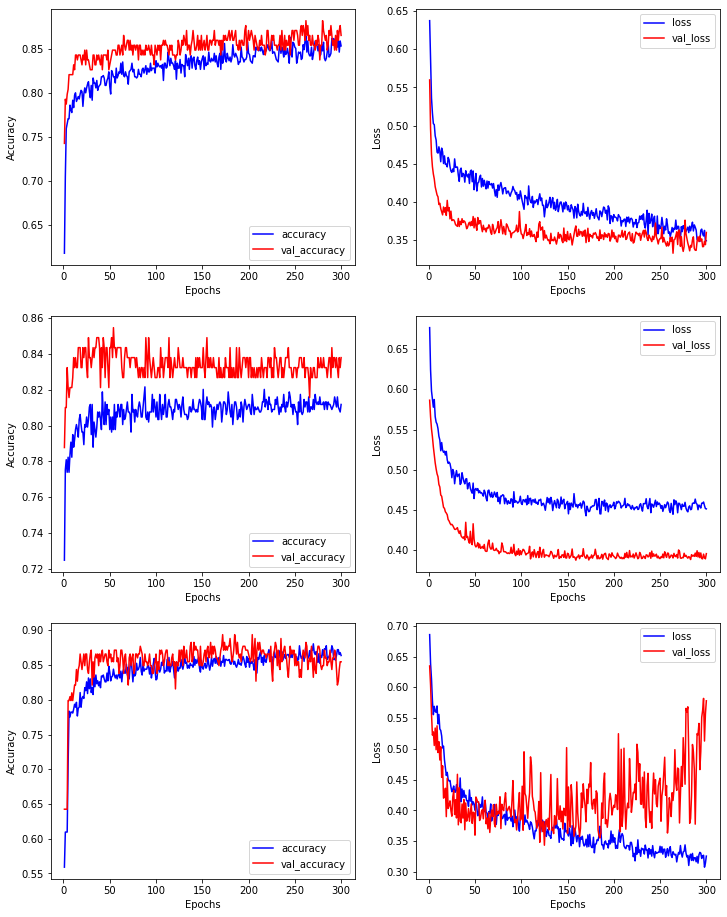

In [55]:
fig, ax = plt.subplots(3, 2, figsize = (12, 16))

accuracy_list = [accuracy_1, accuracy_2, accuracy_3]
val_accuracy_list = [val_accuracy_1, val_accuracy_2, val_accuracy_3]
loss_values_list = [loss_values_1, loss_values_2, loss_values_3]
val_loss_values_list = [val_loss_values_1, val_loss_values_2, val_loss_values_3]

for i in range(0,3):
    ax[i][0].plot(epochs, accuracy_list[i], 'b', label = "accuracy")
    ax[i][0].plot(epochs, val_accuracy_list[i], 'r', label = "val_accuracy")
    ax[i][1].plot(epochs, loss_values_list[i], 'b', label = "loss")
    ax[i][1].plot(epochs, val_loss_values_list[i], 'r', label = "val_loss")
    ax[i][0].set_xlabel("Epochs")
    ax[i][0].set_ylabel("Accuracy")
    ax[i][1].set_xlabel("Epochs")
    ax[i][1].set_ylabel("Loss")
    ax[i][0].legend()
    ax[i][1].legend()
plt.show()

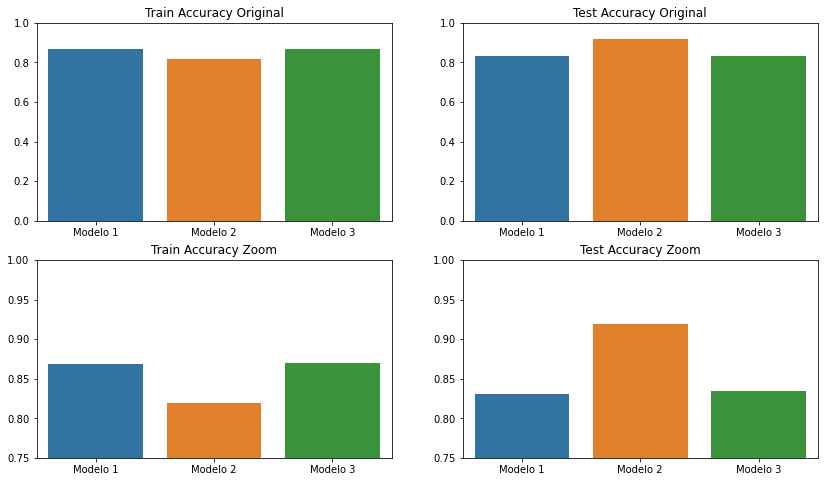

In [57]:
model_list = ["Modelo 1", "Modelo 2", "Modelo 3"]
train_acc_list = [train_acc, train_acc_2, train_acc_3]
test_acc_list = [test_acc, test_acc_2, test_acc_3]

fig, ax = plt.subplots(2, 2, figsize = (14, 8))
# Original
ax[0][0].set_title("Train Accuracy Original")
ax[0][1].set_title("Test Accuracy Original")
ax[0][0].set_ylim(0, 1)
ax[0][1].set_ylim(0, 1)
sns.barplot(x = model_list, y = train_acc_list, ax = ax[0][0])
sns.barplot(x = model_list, y = test_acc_list, ax = ax[0][1])

# Con Zoom
ax[1][0].set_title("Train Accuracy Zoom")
ax[1][1].set_title("Test Accuracy Zoom")
ax[1][0].set_ylim(0.75, 1)
ax[1][1].set_ylim(0.75, 1)
sns.barplot(x = model_list, y = train_acc_list, ax = ax[1][0])
sns.barplot(x = model_list, y = test_acc_list, ax = ax[1][1])
plt.show()